In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

2025-06-24 07:01:03.738849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# wczytanie danych z pliku <span style="color:blue; font-family:Courier; font-size:36pt">csv</span>

In [2]:
data = pd.read_csv('temperature_data.csv')
X = data['day'].values.reshape(-1,1)
y = data['temp'].values

# Normalizacja dla DNN

In [3]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Model regresji liniowej

In [4]:
model_linear = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(1)
])

model_linear.compile(optimizer='adam',loss='mse')
model_linear.fit(X,y,epochs=100,verbose=0)

# Model DNN

In [5]:
model_dnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1)
])

model_dnn.compile(optimizer='adam',loss='mse')
model_dnn.fit(X_scaled,y,epochs=200,verbose=0)

# Prognoza - dni historyczne + 30 dni do przodu

In [6]:
days = data['day'].values
future_days = np.arange(days[-1]+1,days[-1]+31)
all_days = np.concatenate([days,future_days])
all_days_reshaped = all_days.reshape(-1,1) #przygotowanie macierzy o jednej kolumnie dla tf

# Normalizacja przyszłych dni dla DNN

In [7]:
all_days_scaled = scaler_X.transform(all_days_reshaped.clip(X.min(),X.max()))

# Predykcje

In [8]:
y_pred_linear = model_linear.predict(all_days_reshaped).flatten()
y_pred_dnn = model_dnn.predict(all_days_scaled).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


# Zapis prognoz do csv

In [9]:
forecast_df = pd.DataFrame({
    'days':all_days,
    'prediction_linear':y_pred_linear,
    'prediction_dnn':y_pred_dnn
})

forecast_df.to_csv('forecast_comparison.csv',index=False)
print('zapisano do pliku csv...')

zapisano do pliku csv...


# wykres: dane historyczne + prognozy

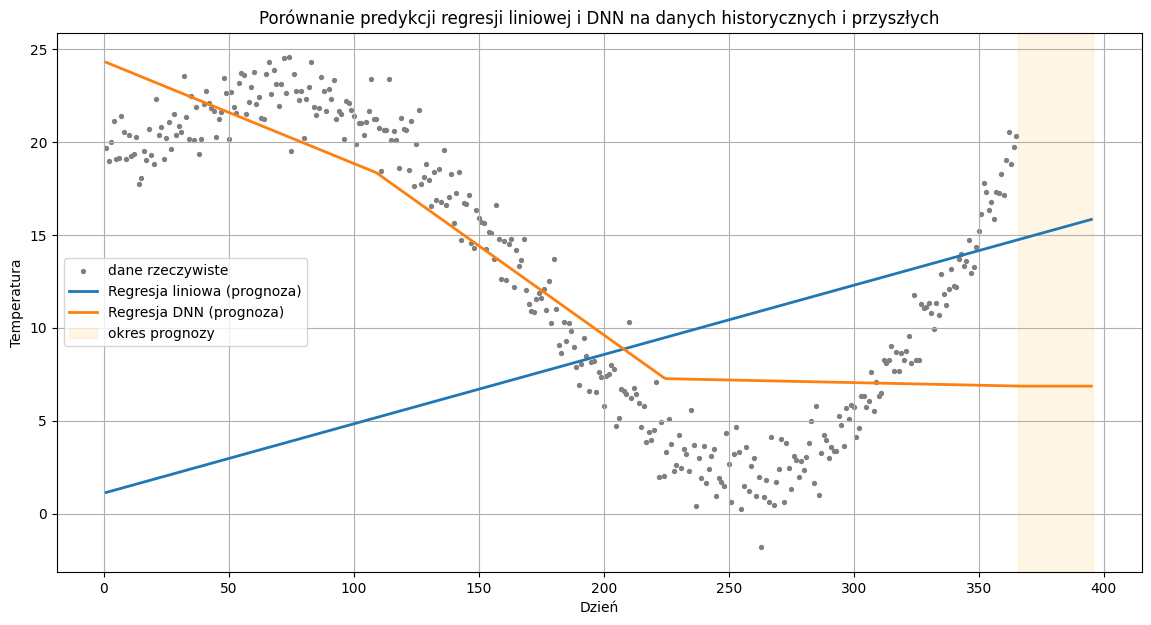

In [10]:
plt.figure(figsize=(14,7))
plt.scatter(days,y,s=8,color='gray',label='dane rzeczywiste')
plt.plot(all_days,y_pred_linear,label='Regresja liniowa (prognoza)', linewidth=2)
plt.plot(all_days,y_pred_dnn,label='Regresja DNN (prognoza)', linewidth=2)
plt.axvspan(days[-1]+0.5,all_days[-1]+0.5,color='orange',alpha=0.1,label='okres prognozy')
plt.legend()
plt.title('Porównanie predykcji regresji liniowej i DNN na danych historycznych i przyszłych')
plt.xlabel('Dzień')
plt.ylabel('Temperatura')
plt.grid(True)
plt.show()